In [1]:
import pandas as pd
import os
import openmatrix as omx
import numpy as np
from itertools import product


_join = os.path.join

In [2]:
# path to the model directory
calibration_data_dir = r"C:\_projects\summary\calibration_targets_data"

# path to the model output directory
calibration_raw_data_dir = _join(calibration_data_dir)

# path to the model data directory
model_dir = r"C:\_projects\ABM_VY\src\asim-cvm"
model_data_dir = _join(model_dir, "data")

In [3]:
# Additional functions
def array2df(array, cols =['orig', 'dest', 'od']):
    """
    Convert a numpy array to a dataframe
    """
    df = pd.DataFrame(array)
    df = pd.melt(df.reset_index(), id_vars='index', value_vars=df.columns)
    df['index'] = df['index'] + 1
    df['variable'] = df['variable'] + 1
    df.columns = cols
    
    return df

In [4]:
## household_attractor
## establishment_attractor
## cvm_accessibility
## route_generation
## route_generation_tnc
## route_purpose_and_vehicle
## route_start_time
## route_origination_type
## route_origination
## route_terminal_type
## route_terminal
## route_stops
## write_cvm_trip_matrices
## write_tables

## Household Attractor Model

In [5]:
# Read input data
df_days = pd.read_csv(_join(calibration_raw_data_dir, r"export_day_weights.csv"))
households = pd.read_csv(_join(calibration_raw_data_dir, r"export_hh_weights_mgra.csv"))
persons = pd.read_csv(_join(calibration_raw_data_dir, r"export_person_weights.csv"))
                                                                            
#df_days.set_index('day_id')

In [6]:
# Filter only eligible participants and weekdays (Mon-Thu)
df_days = df_days[(df_days['is_participant']>0) & (df_days['travel_dow'].isin([1,2,3,4]))]

#### Delivery Variable Definitions

- delivery_2:  Delivery on travel day: Food was delivered to home (e.g., take-out, groceries)
- delivery_3:  Delivery on travel day: Someone came to do work at home (e.g., landscaping, plumber, housecleaning)
- delivery_5:  Delivery on travel day: Received package AT HOME (e.g., USPS, FedEx, UPS)
- delivery_6:  Delivery on travel day: Received personal packages AT WORK
- delivery_7:  Delivery on travel day: Received packages at OFFSITE LOCKER (e.g., Amazon locker, package pick-up point)
- delivery_8:  Delivery on travel day: Other item delivered to home (e.g., appliance)
- delivery_996:  Delivery on travel day: None of the above

In [7]:
# Anywhere that the input for Delivery column is 995, Missing Response, set the value to zero
del_cols = [col for col in df_days if "delivery_" in col]
df_days[del_cols] = df_days[del_cols].replace(995, 0)

In [8]:
# Calculate the max delivery by hh by day
cols = del_cols + ['day_weight']

# Group by 'hh_id' and 'day_num', then check if any column in the group is equal to 1
df_deliv = df_days.groupby(['hh_id', 'day_num'])[cols].max().reset_index()

#df_deliv.head()

In [9]:
for col in cols:
    if "delivery_" in col:
        print(f"{col}: {df_deliv[df_deliv[col]==1][col].sum()}")

delivery_2: 317
delivery_3: 365
delivery_5: 2333
delivery_6: 56
delivery_7: 46
delivery_8: 45
delivery_996: 4465


In [10]:
# Recode
df_deliv['Food'] = df_deliv['delivery_2'] * df_deliv['day_weight']
df_deliv['Service'] = df_deliv['delivery_3'] * df_deliv['day_weight']
df_deliv['Package'] = np.maximum(df_deliv['delivery_5'], df_deliv['delivery_8']) * df_deliv['day_weight']
hh_deliv = df_deliv.copy()

In [11]:
use_cols = ['Food', 'Service', 'Package']
result = round(hh_deliv[use_cols].sum()/hh_deliv['day_weight'].sum(),6)
svy_hh_group = pd.DataFrame(result, columns=['Percentage']).reset_index()


In [12]:
# adding additional attributes from the Households file

# What column to include from the households file
cols_hh = ['hh_id','MGRA', 'num_people', 'income_detailed', 'num_vehicles']

hh = hh_deliv.merge(households[cols_hh], how='left', on='hh_id')
hh.head()

,hh_id,day_num,delivery_2,delivery_3,delivery_5,delivery_6,delivery_7,delivery_8,delivery_996,day_weight,Food,Service,Package,MGRA,num_people,income_detailed,num_vehicles
0,22000077,1,0,0,1,0,0,0,1,58.290764,0.0,0.0,58.290764,5749,2,7,2
1,22000077,2,0,0,0,0,0,0,1,58.290764,0.0,0.0,0.000000,5749,2,7,2
2,22000077,3,0,0,0,0,0,0,1,58.290764,0.0,0.0,0.000000,5749,2,7,2
3,22000077,7,0,0,0,0,0,0,1,58.290764,0.0,0.0,0.000000,5749,2,7,2
4,22000125,3,0,0,0,0,0,0,1,3.140051,0.0,0.0,0.000000,18839,3,7,1


In [13]:
# Relabel the income categories as follows:

    # HHTS Category ---- Summary Category
    # 1  Less than $15,000 ----1
    # 2 $15,000-$24,999 ---- 1
    # 3 $25,000-$34,999 ---- 1 
    # 4 $35,000-$49,999 ---- 1
    # 5 $50,000-$74,999 ---- 2
    # 6 $75,000-$99,999 ---- 2
    # 7 $100,000-$149,999 ---- 3
    # 8 $150,000-$199,999 ---- 3
    # 9 $200,000-$249,999 ---- 4
    # 10 $250,000 or more ---- 4
    # 999 Prefer not to answer ---- 0
    
hhts_inc_cat = {
    1 : 1,
    2 : 1,
    3 : 1,
    4 : 1,
    5 : 2,
    6 : 2,
    7 : 3,
    8 : 3,
    9 : 4,
    10 : 4,
    999 : 0
}


hh['Income_Group'] = hh['income_detailed'].map(hhts_inc_cat)

# Relabel the hh size categories as follows:

    # HHTS Category ---- Summary Category
    # 1   ----1
    # 2  ---- 2
    # 3  ---- 3 
    # 4  ---- 4
    # 5  ---- 5
    # 6  ---- 6+
    # 7  ---- 6+
    # 8  ---- 6+
    # 9  ---- 6+
    # 10  ---- 6+
    # 10  ---- 6+
    # 10  ---- 6+
    # 10  ---- 6+
    # 995 ---- 0
    
hhsize_category_mapping = {
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    5: '5',
    6: '6+',
    7: '6+',
    8: '6+',
    9: '6+',
    10: '6+',
    11: '6+',
    12: '6+',
    13: '6+',
    995: '0',
}


hh['HHsize_Group'] = hh['num_people'].map(hhsize_category_mapping)
hh.head()

,hh_id,day_num,delivery_2,delivery_3,delivery_5,delivery_6,delivery_7,delivery_8,delivery_996,day_weight,Food,Service,Package,MGRA,num_people,income_detailed,num_vehicles,Income_Group,HHsize_Group
0,22000077,1,0,0,1,0,0,0,1,58.290764,0.0,0.0,58.290764,5749,2,7,2,3,2
1,22000077,2,0,0,0,0,0,0,1,58.290764,0.0,0.0,0.000000,5749,2,7,2,3,2
2,22000077,3,0,0,0,0,0,0,1,58.290764,0.0,0.0,0.000000,5749,2,7,2,3,2
3,22000077,7,0,0,0,0,0,0,1,58.290764,0.0,0.0,0.000000,5749,2,7,2,3,2
4,22000125,3,0,0,0,0,0,0,1,3.140051,0.0,0.0,0.000000,18839,3,7,1,3,3


In [14]:
# Relabel the vehicle ownership categories as follows:

    # HHTS Category ---- Summary Category
    # 1   ----1
    # 2  ---- 2
    # 3  ---- 3 
    # 4  ---- 4
    # 5  ---- 5+
    # 6  ---- 5+
    # 7  ---- 5+
    # 8  ---- 5+

veh_category_mapping = {
    1 : '1',
    2 : '2',
    3 : '3',
    4 : '4',
    5 : '5+',
    6 : '5+',
    7 : '5+',
    8 : '5+'
}

hh['Auto_Ownership_Group'] = hh['num_vehicles'].map(veh_category_mapping)

In [15]:
# Categorizing age
persons['Age_Group_3'] = 0
persons.loc[(persons.age >= 1) & (persons.age <=7), 'Age_Group_3'] = 1
persons['Age_Group_1'] = 0
persons.loc[(persons.age >= 8) & (persons.age <=9), 'Age_Group_1'] = 1 # added the max limit of 150, obviously age of more than 150 is not reasonable at least now!!
persons['Age_Group_2'] = 0
persons.loc[(persons.age >=10) & (persons.age <=11), 'Age_Group_2'] = 1

# group persons data to hh level and create binary age group variables
persons_hh = persons.groupby(['hh_id'], as_index=False). agg({
    'Age_Group_1' : 'max',
    'Age_Group_2' : 'max',
    'Age_Group_3' : 'max'
})

hh = pd.merge(hh, persons_hh, how='left', on='hh_id')

# Rename columns
hh.rename(columns={'num_people': 'hhsize', 'income_detailed': 'income', 'num_vehicles' : 'auto_ownership'}, inplace=True)

In [16]:
#CVM Cummary Results: Income
hh_group = hh.groupby(['Income_Group']).sum()[['Food','Package','Service']]
hh_attract = hh.groupby(['Income_Group']).sum()[['day_weight']]
svy_hh_Income = np.divide(hh_group,hh_attract).reset_index()
svy_hh_Income

C:\Users\vyadav\AppData\Local\Temp\2\ipykernel_14276\2023429821.py:4: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  svy_hh_Income = np.divide(hh_group,hh_attract).reset_index()


,Income_Group,Food,Package,Service
0,0,0.031323,0.343338,0.070717
1,1,0.032420,0.276535,0.037632
2,2,0.048692,0.386596,0.053975
3,3,0.062687,0.535169,0.059846
4,4,0.079012,0.570493,0.182796


## Establishment Attractor Model

In [17]:
# Read input data -- establishment file
df_estab = pd.read_excel(os.path.join(calibration_raw_data_dir,
                                      r"SANDAG 2022 CV DataBase & Dictionaires_03_03_2023.xlsx"),
                                     sheet_name=r"Establishment Data")

df_estab.set_index('company_id')
#df_estab.head()

df_estab.loc[:, 'emp_total'] = df_estab['employees_fulltime_count'] + df_estab['employees_parttime_count']

df_expand = pd.read_excel(os.path.join(calibration_raw_data_dir, 
                                      r"CVS_EstabExpansion.xlsx"),
                                     sheet_name=r"CVS_Expansion_Totals")
df_expand.info()
df_expand.SectorID.fillna(0, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SectorID  11 non-null     float64
 1   Sector    12 non-null     object 
 2   Emp_0_9   12 non-null     int64  
 3   Emp_10p   12 non-null     int64  
 4   All       12 non-null     int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 608.0+ bytes


In [18]:
# Create dictionary for establishment expansion targets
expandEstab = dict()
expandEstab['Emp_0_9'] = dict(zip(df_expand['SectorID'],df_expand['Emp_0_9']))
expandEstab['Emp_10p'] = dict(zip(df_expand['SectorID'],df_expand['Emp_10p']))

# Add establishment population-level estimates (targets)
df_estab.loc[df_estab['emp_total']<=9, 'emp_lt10'] = 1
df_estab.loc[df_estab['emp_total']>9, 'emp_lt10'] = 0
df_estab['emp_lt10'] = df_estab['emp_lt10'].astype(int)
             
df_estab.loc[df_estab['emp_total']<=9, \
             'region_estab_wght'] = df_estab['base_location_Industry Group'].map(expandEstab['Emp_0_9'])

df_estab.loc[df_estab['emp_total']>9, \
             'region_estab_wght'] = df_estab['base_location_Industry Group'].map(expandEstab['Emp_10p'])

df_estab['region_estab_wght'] = df_estab['region_estab_wght'].astype('int64')
#df_estab[['emp_total','base_location_Industry Group','emp_lt10','region_estab_wght']].head()

# Calculate Establishment Weights
estab_weights = df_estab.groupby(['region_estab_wght']).size().reset_index(name='num_estabs')
estab_weights['estab_exp_weight'] = estab_weights['region_estab_wght'] / estab_weights['num_estabs']
estab_weights = dict(zip(estab_weights['region_estab_wght'],estab_weights['estab_exp_weight']))

df_estab.loc[:,'estab_exp_weight'] = df_estab['region_estab_wght'].map(estab_weights)
df_estab[['emp_total','base_location_Industry Group','emp_lt10','region_estab_wght','estab_exp_weight']].head(10)
df_estab = df_estab.drop(['region_estab_wght'], axis=1)

In [19]:
# Create industry group abbreviations

ind_fullname = {
1: "Agriculture/Mining",
2: "Manufacturing",
3: "Industrial/Utilities",
4: "Retail",
5: "Wholesale",
6: "Construction",
7: "Transportation",
8: "Info/Finance/Insurance/Real Estate/Professional services",
9: "Education/Other public services",
10: "Medical/Health Services",
11: "Leisure/Accommodations and Food",
96: "Other/Non-Classified"
}

ind_abrv = {
    1: "AGM",
    2: "MFG",
    3: "IUT",
    4: "RET",
    5: "WHL",
    6: "CON",
    7: "TRN",
    8: "IFR",
    9: "EPO",
    10: "MHS",
    11: "LAF",
    96: "OTH"
}

# Reverse lookup
abrv_indus = dict(zip(list(ind_abrv.values()), list(ind_abrv.keys())))

df_estab['industry_abv'] = df_estab['base_location_Industry Group'].map(ind_abrv)

c:\Users\vyadav\.conda\envs\ASIM-DEV\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


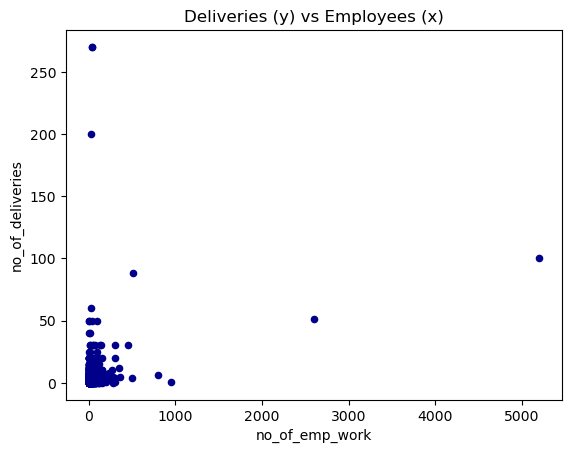

In [20]:
# Scatterplot of employees and devlieries to see outliers
scatter = df_estab.plot.scatter(x='no_of_emp_work', y='no_of_deliveries', c='DarkBlue', title="Deliveries (y) vs Employees (x)")

In [21]:
# Remove outliers - all those with >=500 employees and/or >=50 deliveries (14 total records)
print("Old Shape: ",df_estab.shape)

bound_emp = 500
bound_del = 50

df_estab['outlier'] = np.where( (df_estab['no_of_emp_work']>=bound_emp) | (df_estab['no_of_deliveries']>=bound_del) ,1,0)
df_estab_clean = df_estab #df_estab.drop(df_estab[df_estab.outlier==1].index)

print("New Shape: ",df_estab_clean.shape)

Old Shape:  (2697, 72)
New Shape:  (2697, 73)


In [22]:
# Aggregate Industry Groups (based on the patterns in the above crossclass)
ind_aggregate = {
    "AGM":3,
    "CON":3,
    "EPO":3,
    "IFR":4,
    "IUT":2,
    "LAF":2,
    "MFG":1,
    "MHS":3,
    "RET":1,
    "TRN":3,
    "WHL":1
}
df_estab_clean['ind_aggregate'] = df_estab_clean['industry_abv'].map(ind_aggregate)

# Reverse lookup
aggr_industries = {1:[], 2:[], 3:[], 4:[]}
for key, value in ind_aggregate.items():
        aggr_industries[value] += [key]
print(aggr_industries)

{1: ['MFG', 'RET', 'WHL'], 2: ['IUT', 'LAF'], 3: ['AGM', 'CON', 'EPO', 'MHS', 'TRN'], 4: ['IFR']}


In [23]:
# Create new variable to indicate non-zero delivery establishments
df_estab_clean['nonzero_del'] = np.where( (df_estab_clean['no_of_deliveries']>0), 1, 0 )
df_estab_clean['nonzero_del'].value_counts(normalize=True)

1    0.808306
0    0.191694
Name: nonzero_del, dtype: float64

In [24]:
df_estab_clean['nonzero_del_wtd'] = df_estab_clean['nonzero_del'] * df_estab_clean['estab_exp_weight']
nonZeroDelWtd = df_estab_clean.groupby('ind_aggregate')['nonzero_del_wtd'].sum() 
estabWtd = df_estab_clean.groupby('ind_aggregate')['estab_exp_weight'].sum()
pctNonZeroDelWtd = np.round(nonZeroDelWtd / estabWtd, 4)
pctNonZeroDelWtd = pd.DataFrame(pctNonZeroDelWtd, columns=["pct_nonzero_del"]).reset_index()
pctNonZeroDelWtd['aggr_industries'] = pctNonZeroDelWtd['ind_aggregate'].map(aggr_industries)

svy_est_att_ind_grp = pctNonZeroDelWtd[['ind_aggregate','aggr_industries','pct_nonzero_del']].copy()
print(svy_est_att_ind_grp.to_string(index=False))

 ind_aggregate           aggr_industries  pct_nonzero_del
             1           [MFG, RET, WHL]           0.8756
             2                [IUT, LAF]           0.8424
             3 [AGM, CON, EPO, MHS, TRN]           0.7499
             4                     [IFR]           0.6852


In [25]:
df_estab_deliv = df_estab_clean[df_estab_clean['nonzero_del']==1].copy()
df_estab_deliv['no_of_deliveries_wtd'] = df_estab_deliv['no_of_deliveries'] * df_estab_deliv['estab_exp_weight']
numDelivWtd = df_estab_deliv.groupby('base_location_Industry Group')['no_of_deliveries_wtd'].sum()
estabWtd = df_estab_deliv.groupby('base_location_Industry Group')['estab_exp_weight'].sum()
meanDelivWtd = np.round(numDelivWtd / estabWtd, 4)
meanDelivWtd = pd.DataFrame(meanDelivWtd, columns=["avg_num_deliveries"]).reset_index()
meanDelivWtd['Industry_Group_Name'] = meanDelivWtd['base_location_Industry Group'].map(ind_abrv)

svy_est_att_ind_num = meanDelivWtd[['base_location_Industry Group','Industry_Group_Name','avg_num_deliveries']].copy()
print(svy_est_att_ind_num.to_string(index=False))

 base_location_Industry Group Industry_Group_Name  avg_num_deliveries
                            1                 AGM              2.2144
                            2                 MFG              3.0927
                            3                 IUT              4.3458
                            4                 RET              4.5322
                            5                 WHL              3.3341
                            6                 CON              3.1086
                            7                 TRN              3.7211
                            8                 IFR              2.5834
                            9                 EPO              3.2574
                           10                 MHS              2.2354
                           11                 LAF              3.2430


## Route Generation

In [26]:
# Read input data -- establishment file
df_estab = pd.read_excel(os.path.join(calibration_raw_data_dir,
                                      r"SANDAG 2022 CV DataBase & Dictionaires_03_03_2023.xlsx"),
                                     sheet_name=r"Establishment Data")

df_estab.set_index('company_id')
df_estab.loc[:, 'emp_total'] = df_estab['employees_fulltime_count'] + df_estab['employees_parttime_count']

df_expand = pd.read_excel(os.path.join(calibration_raw_data_dir, 
                                      r"CVS_EstabExpansion.xlsx"),
                                     sheet_name=r"CVS_Expansion_Totals")
df_expand.SectorID.fillna(0, inplace=True)

# Create dictionary for establishment expansion targets
expandEstab = dict()
expandEstab['Emp_0_9'] = dict(zip(df_expand['SectorID'],df_expand['Emp_0_9']))
expandEstab['Emp_10p'] = dict(zip(df_expand['SectorID'],df_expand['Emp_10p']))

# Add establishment population-level estimates (targets)
df_estab.loc[df_estab['emp_total']<=9, 'emp_lt10'] = 1
df_estab.loc[df_estab['emp_total']>9, 'emp_lt10'] = 0
df_estab['emp_lt10'] = df_estab['emp_lt10'].astype(int)
             
df_estab.loc[df_estab['emp_total']<=9, \
             'region_estab_wght'] = df_estab['base_location_Industry Group'].map(expandEstab['Emp_0_9'])

df_estab.loc[df_estab['emp_total']>9, \
             'region_estab_wght'] = df_estab['base_location_Industry Group'].map(expandEstab['Emp_10p'])

df_estab['region_estab_wght'] = df_estab['region_estab_wght'].astype('int64')
#df_estab[['emp_total','base_location_Industry Group','emp_lt10','region_estab_wght']].head()

# Calculate Establishment Weights
estab_weights = df_estab.groupby(['region_estab_wght']).size().reset_index(name='num_estabs')
estab_weights['estab_exp_weight'] = estab_weights['region_estab_wght'] / estab_weights['num_estabs']
estab_weights = dict(zip(estab_weights['region_estab_wght'],estab_weights['estab_exp_weight']))

df_estab.loc[:,'estab_exp_weight'] = df_estab['region_estab_wght'].map(estab_weights)
df_estab[['emp_total','base_location_Industry Group','emp_lt10','region_estab_wght','estab_exp_weight']].head(10)
df_estab = df_estab.drop(['region_estab_wght'], axis=1)

# Finalize Establishment Weights in Table
estab_wts = round(df_estab.groupby(['base_location_Industry Group','emp_lt10'])['estab_exp_weight'].mean().reset_index(),3)

# Create industry group abbreviations

ind_fullname = {
1: "Agriculture/Mining",
2: "Manufacturing",
3: "Industrial/Utilities",
4: "Retail",
5: "Wholesale",
6: "Construction",
7: "Transportation",
8: "Info/Finance/Insurance/Real Estate/Professional services",
9: "Education/Other public services",
10: "Medical/Health Services",
11: "Leisure/Accommodations and Food",
96: "Other/Non-Classified"
}

ind_abrv = {
    1: "AGM",
    2: "MFG",
    3: "IUT",
    4: "RET",
    5: "WHL",
    6: "CON",
    7: "TRN",
    8: "IFR",
    9: "EPO",
    10: "MHS",
    11: "LAF",
    96: "OTH"
}

# Reverse lookup
abrv_indus = dict(zip(list(ind_abrv.values()), list(ind_abrv.keys())))

df_estab['industry_abv'] = df_estab['base_location_Industry Group'].map(ind_abrv)

In [30]:
# Aggregate Industry Groups (based on the patterns in the above crossclass)
ind_aggregate = {
    "AGM": 1,
    "MFG": 1,
    "IUT": 2,
    "RET": 2,
    "WHL": 1,
    "CON": 2,
    "TRN": 2,
    "IFR": 3,
    "EPO": 4,
    "MHS": 4,
    "LAF": 3
    #"MIL": 5
}

df_estab['ind_aggregate'] = df_estab['industry_abv'].map(ind_aggregate)

# Reverse lookup
aggr_industries = {1:[], 2:[], 3:[], 4:[]}
for key, value in ind_aggregate.items():
    aggr_industries[value] += [key]

# Create dependent variable
# we are saying establishment has at least one route if EITHER of the following are true:
# no_of_from_deliveries > 0
# Participated in travel survey
df_estab['routes>0'] = np.where( (df_estab['no_of_from_deliveries']>0) | (df_estab['Participated in Travel Survey?']=="YES"),1,0)

df_estab_clean = df_estab.drop(df_estab[df_estab.no_of_emp_work>1000].index)

In [31]:
df_estab_clean['nonzero_rts_wtd'] = df_estab_clean['routes>0'] * df_estab_clean['estab_exp_weight']
nonZeroRtsWtd = df_estab_clean.groupby('ind_aggregate')['nonzero_rts_wtd'].sum() 
estabWtd = df_estab_clean.groupby('ind_aggregate')['estab_exp_weight'].sum()
pctnonZeroRtsWtd = np.round(nonZeroRtsWtd / estabWtd, 4)
pctnonZeroRtsWtd = pd.DataFrame(pctnonZeroRtsWtd, columns=["pct_nonzero_rts"]).reset_index()
pctnonZeroRtsWtd['aggr_industries'] = pctnonZeroRtsWtd['ind_aggregate'].map(aggr_industries)
pctnonZeroRtsWtd = pctnonZeroRtsWtd[['ind_aggregate', 'aggr_industries', 'pct_nonzero_rts']]
svy_tot_rte_indgrp = pctnonZeroRtsWtd.copy()
svy_tot_rte_indgrp['pct_nonzero_rts'] = svy_tot_rte_indgrp['pct_nonzero_rts'] * 1.2
print(svy_tot_rte_indgrp.to_string(index=False))

 ind_aggregate      aggr_industries  pct_nonzero_rts
             1      [AGM, MFG, WHL]          0.65556
             2 [IUT, RET, CON, TRN]          0.63864
             3           [IFR, LAF]          0.51648
             4           [EPO, MHS]          0.38376


In [32]:
# Survey Data
industries = {
    "Agriculture/Mining" : 1,
    "Construction" : 6,
    "Education/Other public services" : 9,
    "Industrial/Utilities": 3,
    "Info/Finance/Insurance/Real Estate/Professional services": 8,
    "Leisure/Accommodations and Food": 11,
    "Manufacturing" : 2,
    "Medical/Health Services" : 10,
    "Retail" : 4,
    "Transportation" : 7, 
    "Wholesale" : 5,
    "Military" : 12,
}

svy_cvm_routes = pd.read_excel(_join(calibration_data_dir, "CV_Routes_20240129.xlsx"))
svy_cvm_routes['industry_group'] = svy_cvm_routes['industry_group'].str.strip()
svy_cvm_routes['industry_num'] = svy_cvm_routes['industry_group'].map(industries)


svy_tot_rte_indnum = svy_cvm_routes.groupby(['industry_num'])['expnsn_factor'].sum().reset_index().rename(
    columns={'expnsn_factor': 'total_routes'})

In [33]:
svy_cvm_routes['group'] = 0

# Assign the group based on the route purpose, customer type and vehicle type
svy_cvm_routes.loc[(svy_cvm_routes['primary_purp'] == 'Goods') & 
                 (svy_cvm_routes['customer_type'] == 'Mixed Residential and Non-residential') & 
                 (svy_cvm_routes['veh_type'] == 'LCV'), 'group'] = 'Goods_Mixed_LCV'

svy_cvm_routes.loc[(svy_cvm_routes['primary_purp'] == 'Goods') & 
                 (svy_cvm_routes['customer_type'] == 'Mixed Residential and Non-residential') & 
                 (svy_cvm_routes['veh_type'] == 'MUT'), 'group'] = 'Goods_Mixed_MUT'

svy_cvm_routes.loc[(svy_cvm_routes['primary_purp'] == 'Goods') & 
                 (svy_cvm_routes['customer_type'] == 'Mixed Residential and Non-residential') & 
                 (svy_cvm_routes['veh_type'] == 'SUT'), 'group'] = 'Goods_Mixed_SUT'

svy_cvm_routes.loc[(svy_cvm_routes['primary_purp'] == 'Goods') & 
                 (svy_cvm_routes['customer_type'] == 'Non-Residential Only') & 
                 (svy_cvm_routes['veh_type'] == 'LCV'), 'group'] = 'Goods_NonRes_LCV'

svy_cvm_routes.loc[(svy_cvm_routes['primary_purp'] == 'Goods') & 
                 (svy_cvm_routes['customer_type'] == 'Non-Residential Only') & 
                 (svy_cvm_routes['veh_type'] == 'MUT'), 'group'] = 'Goods_NonRes_MUT'

svy_cvm_routes.loc[(svy_cvm_routes['primary_purp'] == 'Goods') & 
                 (svy_cvm_routes['customer_type'] == 'Non-Residential Only') & 
                 (svy_cvm_routes['veh_type'] == 'SUT'), 'group'] = 'Goods_NonRes_SUT'

svy_cvm_routes.loc[(svy_cvm_routes['primary_purp'] == 'Goods') & 
                 (svy_cvm_routes['customer_type'] == 'Residential Only') & 
                 (svy_cvm_routes['veh_type'] == 'LCV'), 'group'] = 'Goods_Res_LCV'

svy_cvm_routes.loc[(svy_cvm_routes['primary_purp'] == 'Goods') & 
                 (svy_cvm_routes['customer_type'] == 'Residential Only') & 
                 (svy_cvm_routes['veh_type'] == 'MUT'), 'group'] = 'Goods_Res_MUT'

svy_cvm_routes.loc[(svy_cvm_routes['primary_purp'] == 'Goods') & 
                 (svy_cvm_routes['customer_type'] == 'Residential Only') & 
                 (svy_cvm_routes['veh_type'] == 'SUT'), 'group'] = 'Goods_Res_SUT'

svy_cvm_routes.loc[(svy_cvm_routes['primary_purp'] == 'Maintenance/Other') & 
                 (svy_cvm_routes['veh_type'] == 'LCV'), 'group'] = 'Maintenance_LCV'

svy_cvm_routes.loc[(svy_cvm_routes['primary_purp'] == 'Maintenance/Other') & 
                 (svy_cvm_routes['veh_type'] == 'MUT'), 'group'] = 'Maintenance_MUT'

svy_cvm_routes.loc[(svy_cvm_routes['primary_purp'] == 'Maintenance/Other') & 
                 (svy_cvm_routes['veh_type'] == 'SUT'), 'group'] = 'Maintenance_SUT'

svy_cvm_routes.loc[(svy_cvm_routes['primary_purp'] == 'Service') & 
                 (svy_cvm_routes['customer_type'] == 'Mixed Residential and Non-residential') & 
                 (svy_cvm_routes['veh_type'] == 'LCV'), 'group'] = 'Service_Mixed_LCV'

svy_cvm_routes.loc[(svy_cvm_routes['primary_purp'] == 'Service') & 
                 (svy_cvm_routes['customer_type'] == 'Mixed Residential and Non-residential') & 
                 (svy_cvm_routes['veh_type'] == 'MUT'), 'group'] = 'Service_Mixed_MUT'

svy_cvm_routes.loc[(svy_cvm_routes['primary_purp'] == 'Service') & 
                 (svy_cvm_routes['customer_type'] == 'Mixed Residential and Non-residential') & 
                 (svy_cvm_routes['veh_type'] == 'SUT'), 'group'] = 'Service_Mixed_SUT'

svy_cvm_routes.loc[(svy_cvm_routes['primary_purp'] == 'Service') & 
                 (svy_cvm_routes['customer_type'] == 'Non-Residential Only') & 
                 (svy_cvm_routes['veh_type'] == 'LCV'), 'group'] = 'Service_NonRes_LCV'

svy_cvm_routes.loc[(svy_cvm_routes['primary_purp'] == 'Service') & 
                 (svy_cvm_routes['customer_type'] == 'Non-Residential Only') & 
                 (svy_cvm_routes['veh_type'] == 'MUT'), 'group'] = 'Service_NonRes_MUT'

svy_cvm_routes.loc[(svy_cvm_routes['primary_purp'] == 'Service') & 
                 (svy_cvm_routes['customer_type'] == 'Non-Residential Only') & 
                 (svy_cvm_routes['veh_type'] == 'SUT'), 'group'] = 'Service_NonRes_SUT'

svy_cvm_routes.loc[(svy_cvm_routes['primary_purp'] == 'Service') & 
                 (svy_cvm_routes['customer_type'] == 'Residential Only') & 
                 (svy_cvm_routes['veh_type'] == 'LCV'), 'group'] = 'Service_Res_LCV'

svy_cvm_routes.loc[(svy_cvm_routes['primary_purp'] == 'Service') & 
                 (svy_cvm_routes['customer_type'] == 'Residential Only') & 
                 (svy_cvm_routes['veh_type'] == 'MUT'), 'group'] = 'Service_Res_MUT'

svy_cvm_routes.loc[(svy_cvm_routes['primary_purp'] == 'Service') & 
                 (svy_cvm_routes['customer_type'] == 'Residential Only') & 
                 (svy_cvm_routes['veh_type'] == 'SUT'), 'group'] = 'Service_Res_SUT'

In [34]:
vpc_alt = {
    "Goods_Mixed_LCV":1,
    "Goods_Mixed_MUT":2,
    "Goods_Mixed_SUT":3,
    "Goods_NonRes_LCV":4,
    "Goods_NonRes_MUT":5,
    "Goods_NonRes_SUT":6,
    "Goods_Res_LCV":7,
    "Goods_Res_MUT":8,
    "Goods_Res_SUT":9,
    "Maintenance_LCV":10,
    "Maintenance_MUT":11,
    "Maintenance_SUT":12,
    "Service_Mixed_LCV":13,
    "Service_Mixed_MUT":14,
    "Service_Mixed_SUT":15,
    "Service_NonRes_LCV":16,
    "Service_NonRes_MUT":17,
    "Service_NonRes_SUT":18,
    "Service_Res_LCV":19,
    "Service_Res_MUT":20,
    "Service_Res_SUT":21,
}

# Map the group to the vpc_alt
svy_cvm_routes['vpc_alt'] = svy_cvm_routes['group'].map(vpc_alt)

# route generation by industry group
route_purp_veh_smry = svy_cvm_routes.groupby(['vpc_alt', 'group'])['expnsn_factor'].sum().reset_index()

In [35]:
# Route Generation - TNC
svy_tnc_routes = pd.read_excel(_join(calibration_data_dir, "TNC_Routes_20240129.xlsx"))

# Expansion weights dictionary
tnc_expwght = {'TNC_NonRestRetl': 3.78289, 'TNC_Restaurant': 12.86792, 'TNC_Retail': 19.11675}
svy_tnc_routes['expnsn_factor'] = svy_tnc_routes['expnsn_factor'].astype('float')
svy_tnc_routes.loc[:, 'expnsn_factor'] = svy_tnc_routes['industry_group'].map(tnc_expwght)

svy_cvm_tnc_rte_gen = svy_tnc_routes.groupby(['industry_group'])['expnsn_factor'].sum().reset_index()

# Get TNC Route Start times
svy_tnc_st = svy_tnc_routes[['route_id','start_tod', 'expnsn_factor']].copy()

# Extract hour and minute from start_tod
svy_tnc_st['Hour'] = svy_tnc_st['start_tod'].dt.hour
svy_tnc_st['Minute'] = svy_tnc_st['start_tod'].dt.minute
svy_tnc_st['Minute_Round'] = svy_tnc_st['Minute'].apply(lambda x: 0 if x < 30 else 0.5)
svy_tnc_st['Hour_Minute'] = svy_tnc_st['Hour'] + svy_tnc_st['Minute_Round']
svy_tnc_st['Hour_Minute'] = svy_tnc_st['Hour_Minute'].apply(lambda x: round(x, 2))

# Assign TOD based on Hour_Minute
tod_tnc_smry = svy_tnc_st.groupby(['Hour_Minute'])['expnsn_factor'].sum().reset_index()
tod_tnc_smry['TOD'] = 'NA'
tod_tnc_smry.loc[(tod_tnc_smry['Hour_Minute'] >= 3.0) & (tod_tnc_smry['Hour_Minute'] <6.0), 'TOD'] = 'EA'
tod_tnc_smry.loc[(tod_tnc_smry['Hour_Minute'] >= 6.0) & (tod_tnc_smry['Hour_Minute'] <9.0), 'TOD'] = 'AM'
tod_tnc_smry.loc[(tod_tnc_smry['Hour_Minute'] >= 9.0) & (tod_tnc_smry['Hour_Minute'] <15.5), 'TOD'] = 'MD'
tod_tnc_smry.loc[(tod_tnc_smry['Hour_Minute'] >= 15.5) & (tod_tnc_smry['Hour_Minute'] <19.0), 'TOD'] = 'PM'
tod_tnc_smry.loc[(tod_tnc_smry['Hour_Minute'] >= 19.0) & (tod_tnc_smry['Hour_Minute'] <24.0), 'TOD'] = 'EV'
tod_tnc_smry.loc[(tod_tnc_smry['Hour_Minute'] >= 0.0) & (tod_tnc_smry['Hour_Minute'] <3.0), 'TOD'] = 'EV'

# Group by TOD and calculate the sum of expnsn_factor for CVM routes
svy_rte_tnc_start_time_period = tod_tnc_smry.groupby(['TOD'])['expnsn_factor'].sum().reset_index()

## Route Start Time

In [36]:
# Read the CVM Routes file
svy_cvm_routes = pd.read_excel(_join(calibration_data_dir, "CV_Routes_20240129.xlsx"))
svy_cvm_st = svy_cvm_routes[['route_id','start_tod', 'expnsn_factor']].copy()

# Extract hour and minute from start_tod
svy_cvm_st['Hour'] = svy_cvm_st['start_tod'].dt.hour
svy_cvm_st['Minute'] = svy_cvm_st['start_tod'].dt.minute
svy_cvm_st['Minute_Round'] = svy_cvm_st['Minute'].apply(lambda x: 0 if x < 30 else 0.5)
svy_cvm_st['Hour_Minute'] = svy_cvm_st['Hour'] + svy_cvm_st['Minute_Round']
svy_cvm_st['Hour_Minute'] = svy_cvm_st['Hour_Minute'].apply(lambda x: round(x, 2))

# Assign TOD based on Hour_Minute
tod_smry = svy_cvm_st.groupby(['Hour_Minute'])['expnsn_factor'].sum().reset_index()
tod_smry['TOD'] = 'NA'
tod_smry.loc[(tod_smry['Hour_Minute'] >= 3.0) & (tod_smry['Hour_Minute'] <6.0), 'TOD'] = 'EA'
tod_smry.loc[(tod_smry['Hour_Minute'] >= 6.0) & (tod_smry['Hour_Minute'] <9.0), 'TOD'] = 'AM'
tod_smry.loc[(tod_smry['Hour_Minute'] >= 9.0) & (tod_smry['Hour_Minute'] <15.5), 'TOD'] = 'MD'
tod_smry.loc[(tod_smry['Hour_Minute'] >= 15.5) & (tod_smry['Hour_Minute'] <19.0), 'TOD'] = 'PM'
tod_smry.loc[(tod_smry['Hour_Minute'] >= 19.0) & (tod_smry['Hour_Minute'] <24.0), 'TOD'] = 'EV'
tod_smry.loc[(tod_smry['Hour_Minute'] >= 0.0) & (tod_smry['Hour_Minute'] <3.0), 'TOD'] = 'EV'

# Group by TOD and calculate the sum of expnsn_factor for CVM routes
svy_rte_start_time_period = tod_smry.groupby(['TOD'])['expnsn_factor'].sum().reset_index()

## Route Origination Terminal Type


In [37]:
# input files
svy_cvm_routes = pd.read_excel(_join(calibration_data_dir, "CV_Routes_20240129.xlsx"))
svy_tnc_routes = pd.read_excel(_join(calibration_data_dir, "TNC_Routes_20240129.xlsx"))

# get AM distances from skims for each mode for origin
skims_dist = omx.open_file(_join(model_data_dir, "traffic_skims_AM.omx"))
lcv_am_dist = array2df(np.array(skims_dist['TRK_L_DIST__AM']), cols=['orig', 'dest', 'am_dist'])
sut_am_dist = array2df(np.array(skims_dist['TRK_M_DIST__AM']), cols=['orig', 'dest', 'am_dist'])
mut_am_dist = array2df(np.array(skims_dist['TRK_H_DIST__AM']), cols=['orig', 'dest', 'am_dist'])
skims_dist.close()

# get MD distances from skims for each mode for terminal
skims_dist = omx.open_file(_join(model_data_dir, "traffic_skims_MD.omx"))
lcv_md_dist = array2df(np.array(skims_dist['TRK_L_DIST__MD']), cols=['orig', 'dest', 'md_dist'])
sut_md_dist = array2df(np.array(skims_dist['TRK_M_DIST__MD']), cols=['orig', 'dest', 'md_dist'])
mut_md_dist = array2df(np.array(skims_dist['TRK_H_DIST__MD']), cols=['orig', 'dest', 'md_dist'])
skims_dist.close()

In [38]:
# merge distances with routes for each mode - from establishment to origin
print(len(svy_cvm_routes))
svy_lcv_routes = svy_cvm_routes[svy_cvm_routes['veh_type'] == 'LCV']
svy_lcv_routes = pd.merge(svy_lcv_routes, lcv_am_dist, left_on=['estab_taz', 'orig_taz'], right_on=['orig', 'dest'], how='left')

svy_sut_routes = svy_cvm_routes[svy_cvm_routes['veh_type'] == 'SUT']
svy_sut_routes = pd.merge(svy_sut_routes, sut_am_dist, left_on=['estab_taz', 'orig_taz'], right_on=['orig', 'dest'], how='left')

svy_mut_routes = svy_cvm_routes[svy_cvm_routes['veh_type'] == 'MUT']
svy_mut_routes = pd.merge(svy_mut_routes, mut_am_dist, left_on=['estab_taz', 'orig_taz'], right_on=['orig', 'dest'], how='left')

svy_cvm_routes = pd.concat([svy_lcv_routes, svy_sut_routes, svy_mut_routes])
svy_cvm_routes = svy_cvm_routes.reset_index(drop=True)

svy_cvm_routes = svy_cvm_routes.rename(columns={'am_dist': 'dist_estab2orig'})
print(len(svy_cvm_routes))

1574
1574


In [39]:
# merge distances with routes for each mode - from establishment to destination
print(len(svy_cvm_routes))
svy_lcv_routes = svy_cvm_routes[svy_cvm_routes['veh_type'] == 'LCV']
svy_lcv_routes = pd.merge(svy_lcv_routes, lcv_md_dist, left_on=['estab_taz', 'dest_taz'], right_on=['orig', 'dest'], how='left')

svy_sut_routes = svy_cvm_routes[svy_cvm_routes['veh_type'] == 'SUT']
svy_sut_routes = pd.merge(svy_sut_routes, sut_md_dist, left_on=['estab_taz', 'dest_taz'], right_on=['orig', 'dest'], how='left')

svy_mut_routes = svy_cvm_routes[svy_cvm_routes['veh_type'] == 'MUT']
svy_mut_routes = pd.merge(svy_mut_routes, mut_md_dist, left_on=['estab_taz', 'dest_taz'], right_on=['orig', 'dest'], how='left')

svy_cvm_routes = pd.concat([svy_lcv_routes, svy_sut_routes, svy_mut_routes])
svy_cvm_routes = svy_cvm_routes.reset_index(drop=True)

svy_cvm_routes = svy_cvm_routes.rename(columns={'md_dist': 'dist_estab2dest'})
print(len(svy_cvm_routes))

1574
1574


In [40]:
svy_cv_routes_non_na_estab_orig = svy_cvm_routes[svy_cvm_routes['dist_estab2orig'].notna()] #some orig_taz couldn't be geolocated
svy_cv_routes_non_na_orig_dest = svy_cvm_routes[svy_cvm_routes['dist_estab2dest'].notna()] #some dest_taz couldn't be geolocated
print(len(svy_cv_routes_non_na_estab_orig))
print(len(svy_cv_routes_non_na_orig_dest))
#cv_routes_na[['estab_taz','orig_taz']]

1550
1528


In [41]:
svy_indg_orig_type = svy_cv_routes_non_na_estab_orig.groupby(['orig_type', 'industry_group'])['expnsn_factor'].sum().reset_index()
svy_veh_orig_type = svy_cv_routes_non_na_estab_orig.groupby(['orig_type', 'veh_type'])['expnsn_factor'].sum().reset_index()

svy_cv_routes_non_na_estab_orig['dist_estab2orig_wtd'] = svy_cv_routes_non_na_estab_orig['expnsn_factor'] * svy_cv_routes_non_na_estab_orig['dist_estab2orig']
svy_veh_orig_type_mean_dist1 = svy_cv_routes_non_na_estab_orig.groupby(['orig_type'])['dist_estab2orig_wtd'].sum().reset_index()
svy_veh_orig_type_mean_dist2 = svy_cv_routes_non_na_estab_orig.groupby(['orig_type'])['expnsn_factor'].sum().reset_index()

svy_veh_orig_type_mean_dist = pd.merge(svy_veh_orig_type_mean_dist1, svy_veh_orig_type_mean_dist2, on=['orig_type'])
svy_veh_orig_type_mean_dist['mean_dist'] = svy_veh_orig_type_mean_dist['dist_estab2orig_wtd'] / svy_veh_orig_type_mean_dist['expnsn_factor']
svy_veh_orig_type_mean_dist = svy_veh_orig_type_mean_dist[['orig_type', 'mean_dist']]

svy_indg_dest_type = svy_cv_routes_non_na_orig_dest.groupby(['dest_type', 'industry_group'])['expnsn_factor'].sum().reset_index()
svy_veh_dest_type = svy_cv_routes_non_na_orig_dest.groupby(['dest_type', 'veh_type'])['expnsn_factor'].sum().reset_index()

svy_veh_dest_type_mean_dist1 = svy_cv_routes_non_na_estab_orig.groupby(['dest_type',])['dist_estab2orig_wtd'].sum().reset_index()
svy_veh_dest_type_mean_dist2 = svy_cv_routes_non_na_estab_orig.groupby(['dest_type',])['expnsn_factor'].sum().reset_index()
svy_veh_dest_type_mean_dist = pd.merge(svy_veh_dest_type_mean_dist1, svy_veh_dest_type_mean_dist2, on=['dest_type'])
svy_veh_dest_type_mean_dist['mean_dist'] = svy_veh_dest_type_mean_dist['dist_estab2orig_wtd'] / svy_veh_dest_type_mean_dist['expnsn_factor']
svy_veh_dest_type_mean_dist = svy_veh_dest_type_mean_dist[['dest_type', 'mean_dist']]

C:\Users\vyadav\AppData\Local\Temp\2\ipykernel_14276\15898905.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svy_cv_routes_non_na_estab_orig['dist_estab2orig_wtd'] = svy_cv_routes_non_na_estab_orig['expnsn_factor'] * svy_cv_routes_non_na_estab_orig['dist_estab2orig']


## Next Stop location

In [42]:
# get distances from skims for each mode
time_period = ['AM', 'MD', 'PM', 'EV', 'EA']

for tp in time_period:
    skims_dist = omx.open_file(_join(model_data_dir, "traffic_skims_" + tp + ".omx"))
    globals()['lcv_' + tp.lower() + '_dist'] = array2df(np.array(skims_dist['TRK_L_DIST__' + tp]), cols=['orig', 'dest', '_dist'])
    globals()['sut_' + tp.lower() + '_dist'] = array2df(np.array(skims_dist['TRK_M_DIST__' + tp]), cols=['orig', 'dest', '_dist'])
    globals()['mut_' + tp.lower() + '_dist'] = array2df(np.array(skims_dist['TRK_H_DIST__' + tp]), cols=['orig', 'dest', '_dist'])
    globals()['tnc_' + tp.lower() + '_dist'] = array2df(np.array(skims_dist['TRK_L_DIST__' + tp]), cols=['orig', 'dest', '_dist'])
    skims_dist.close()

In [43]:
#input files
svy_cvm_trips = pd.read_excel(_join(calibration_data_dir, "CV_Trips_20240129.xlsx"))
svy_tnc_trips = pd.read_excel(_join(calibration_data_dir, "TNC_Trips_20240129.xlsx"))

In [44]:
tod_crwk = pd.read_csv(_join("tod_crswlk.csv"))
tod_crwk = dict(zip(tod_crwk['start_time'], tod_crwk['time_period']))

In [45]:
svy_purposes = ['Base', 'Goods_Delivery', 'Goods_Pickup', 'Home', 'Maintenance/Other', 'Originate', 'Service', 'Terminal Destination']
svy_purp_smry_temp = pd.DataFrame(list(product(svy_purposes, repeat=2)), columns=['o_act_seg_name', 'd_act_seg_name'])

tod = ['AM', 'MD', 'PM', 'EV', 'EA']

vtype = ['LCV' , 'SUT', 'MUT']
svy_vtype_smry_temp = pd.DataFrame(list(vtype), columns=['veh_type'])

svy_dtype = ['OtherNonResidential', 'Residential', 'Base', 'Warehouse', 'TransportNode']
svy_dtype_smry_temp = pd.DataFrame(list(svy_dtype), columns=['dest_type'])

In [46]:
# add distance based on time period to svy data
print(f"Before Merge {len(svy_cvm_trips)}")

svy_all_cvm_trips = []
vehicles = ['lcv', 'sut', 'mut']
for tp in time_period:
    for vehicle in vehicles:
        svy_temp = svy_cvm_trips.loc[(svy_cvm_trips['tod'] == tp) & (svy_cvm_trips['veh_type'] == vehicle.upper())]
        svy_trips = svy_temp.merge(globals()[vehicle + '_' + tp.lower() + '_dist'], left_on=['o_taz', 'd_taz'], right_on=['orig', 'dest'], how='left')
        svy_trips = svy_trips.drop(['orig', 'dest'], axis=1)
        svy_all_cvm_trips.append(svy_trips)

svy_cvm_trips_test = pd.concat(svy_all_cvm_trips)
print(f"After Merge {len(svy_cvm_trips_test)}")

Before Merge 10687
After Merge 10687


In [47]:
svy_cvm_trips = svy_cvm_trips_test.copy()
svy_cvm_trips.loc[svy_cvm_trips['trip_number'] == 1, 'o_act_seg_name'] = 'Originate'
svy_cvm_trips.loc[svy_cvm_trips['last_trip'] == True, 'd_act_seg_name'] = 'Terminal Destination'
svy_cvm_trips['route_start_hour'] = svy_cvm_trips['route_start_time'].dt.hour

# filtering trips from Base to Base and Home to Home
svy_cvm_trips = svy_cvm_trips[~((svy_cvm_trips['o_act_seg_name'] == 'Base') & (svy_cvm_trips['d_act_seg_name'] == 'Base'))]
svy_cvm_trips = svy_cvm_trips[~((svy_cvm_trips['o_act_seg_name'] == 'Home') & (svy_cvm_trips['d_act_seg_name'] == 'Home'))]

In [48]:
# total trips by origin and destination activity segment name
svy_od_act_seg_name = svy_cvm_trips.groupby(['o_act_seg_name', 'd_act_seg_name'])['expnsn_factor'].sum().reset_index()
svy_od_act_seg_name = svy_purp_smry_temp.merge(svy_od_act_seg_name, on=['o_act_seg_name', 'd_act_seg_name'], how='left')
svy_od_act_seg_name = svy_od_act_seg_name.fillna(0)
svy_od_act_seg_name = svy_od_act_seg_name.pivot(index='o_act_seg_name', columns='d_act_seg_name', values='expnsn_factor').reset_index()

# total trips by time period
svy_cvm_tod_smry = svy_cvm_trips.groupby(['tod'])['expnsn_factor'].sum().reset_index()

In [49]:
# Mean distance by vehicle type
svy_cvm_trips['dist_xExpsn'] = svy_cvm_trips['_dist'] * svy_cvm_trips['expnsn_factor']
svy_cvm_mean_dist_vtype1 = svy_cvm_trips.groupby(['veh_type'])['dist_xExpsn'].sum().reset_index()
svy_cvm_mean_dist_vtype2 = svy_cvm_trips.groupby(['veh_type'])['expnsn_factor'].sum().reset_index()
svy_cvm_mean_dist_vtype = svy_cvm_mean_dist_vtype1.merge(svy_cvm_mean_dist_vtype2, on='veh_type')
svy_cvm_mean_dist_vtype['mean_dist'] = svy_cvm_mean_dist_vtype['dist_xExpsn'] / svy_cvm_mean_dist_vtype['expnsn_factor']
svy_cvm_mean_dist_vtype = svy_cvm_mean_dist_vtype[['veh_type', 'mean_dist']]

In [50]:
# total trips by destination type
svy_cvm_dest_type = svy_cvm_trips.groupby(['dest_type'])['expnsn_factor'].sum().reset_index()
svy_cvm_dest_type = svy_dtype_smry_temp.merge(svy_cvm_dest_type, on='dest_type', how='left')

In [51]:
svy_tnc_trips = pd.read_excel(_join(calibration_data_dir, "TNC_Trips_20240129.xlsx"))

# Expansion weights dictionary
tnc_expwght = {'TNC_NonRestRetl': 3.78289, 'TNC_Restaurant': 12.86792, 'TNC_Retail': 19.11675}
svy_tnc_trips['expnsn_factor'] = svy_tnc_trips['expnsn_factor'].astype('float')
svy_tnc_trips.loc[:, 'expnsn_factor'] = svy_tnc_trips['industry_group'].map(tnc_expwght)

In [52]:
# add distance bases on time period to svy data
print(f"Before Merge {len(svy_tnc_trips)}")

svy_all_tnc_trips = []
vehicles = 'tnc'
for tp in time_period:
        svy_temp = svy_tnc_trips.loc[(svy_tnc_trips['tod'] == tp)]
        svy_trips = svy_temp.merge(globals()[vehicles + '_' + tp.lower() + '_dist'], left_on=['o_taz', 'd_taz'], right_on=['orig', 'dest'], how='left')
        svy_trips = svy_trips.drop(['orig', 'dest'], axis=1)
        svy_all_tnc_trips.append(svy_trips)

svy_tnc_trips_test = pd.concat(svy_all_tnc_trips)
print(f"After Merge {len(svy_tnc_trips_test)}")

Before Merge 5253
After Merge 5253


In [53]:
svy_tnc_trips = svy_tnc_trips_test.copy()
svy_tnc_trips.loc[svy_tnc_trips['trip_number'] == 1, 'o_act_seg_name'] = 'Originate'

svy_tnc_trips.loc[svy_tnc_trips['last_trip'] == True, 'd_act_seg_name'] = 'Terminal Destination'
svy_tnc_trips = svy_tnc_trips[~((svy_tnc_trips['o_act_seg_name'] == 'Base') & (svy_tnc_trips['d_act_seg_name'] == 'Base'))]
svy_tnc_trips = svy_tnc_trips[~((svy_tnc_trips['o_act_seg_name'] == 'Home') & (svy_tnc_trips['d_act_seg_name'] == 'Home'))]                       

In [54]:
# summaries for TNC trips
svy_tnc_od_act_seg_name = svy_tnc_trips.groupby(['o_act_seg_name', 'd_act_seg_name'])['expnsn_factor'].sum().reset_index()
svy_tnc_od_act_seg_name = svy_purp_smry_temp.merge(svy_tnc_od_act_seg_name, on=['o_act_seg_name', 'd_act_seg_name'], how='left')
svy_tnc_od_act_seg_name = svy_tnc_od_act_seg_name.fillna(0)
svy_tnc_od_act_seg_name = svy_tnc_od_act_seg_name.pivot(index='o_act_seg_name', columns='d_act_seg_name', values='expnsn_factor').reset_index()

svy_tnc_tod_smry = svy_tnc_trips.groupby(['tod'])['expnsn_factor'].sum().reset_index()
svy_tnc_trp_dest_type = svy_tnc_trips.groupby(['dest_type'])['expnsn_factor'].sum().reset_index()

In [55]:
# TNC - mean distance by vehicle type
svy_tnc_trips['veh_type'] = 'LCV'
svy_tnc_trips['dist_xEspsn'] = svy_tnc_trips['_dist'] * svy_tnc_trips['expnsn_factor']
svy_tnc_mean_dist_vtype1 = svy_tnc_trips.groupby('veh_type')['dist_xEspsn'].sum().reset_index()
svy_tnc_mean_dist_vtype2 = svy_tnc_trips.groupby('veh_type')['expnsn_factor'].sum().reset_index()
svy_tnc_mean_dist_vtype = svy_tnc_mean_dist_vtype1.merge(svy_tnc_mean_dist_vtype2, on='veh_type')
svy_tnc_mean_dist_vtype['mean_dist'] = svy_tnc_mean_dist_vtype['dist_xEspsn'] / svy_tnc_mean_dist_vtype['expnsn_factor']
svy_tnc_mean_dist_vtype = svy_tnc_mean_dist_vtype.drop(['dist_xEspsn', 'expnsn_factor'], axis=1)
svy_tnc_mean_dist_vtype = svy_vtype_smry_temp.merge(svy_tnc_mean_dist_vtype, on='veh_type' , how = 'left')

In [56]:
# TNC Trips TOD
svy_cvm_trips_tnc_tod_smry = svy_tnc_trips.groupby(['tod'])['expnsn_factor'].sum().reset_index()

In [58]:
# Create an Excel writer object
writer = pd.ExcelWriter('Final_CVM_Survey_Summary.xlsx')

# Household Attractor Model
svy_hh_group.to_excel(writer, sheet_name='SurveyData', startrow=2 , startcol=0, index=False)
svy_hh_Income.to_excel(writer, sheet_name='SurveyData', startrow=2 , startcol=5, index=False)
#svy_hh_Age_1.to_excel(writer, sheet_name='SurveyData', startrow=2 , startcol=10, index=False)
#svy_hh_Age_2.to_excel(writer, sheet_name='SurveyData', startrow=2 , startcol=15, index=False)
#svy_hh_Age_3.to_excel(writer, sheet_name='SurveyData', startrow=2 , startcol=20, index=False)

# Establishment Attractor Model
svy_est_att_ind_grp.to_excel(writer, sheet_name='SurveyData', startrow=2 , startcol=25, index=False)
svy_est_att_ind_num.to_excel(writer, sheet_name='SurveyData', startrow=2 , startcol=30, index=False)

svy_tot_rte_indgrp.to_excel(writer, sheet_name='SurveyData', startrow=2 , startcol=35, index=False)
svy_tot_rte_indnum.to_excel(writer, sheet_name='SurveyData', startrow=2 , startcol=40, index=False)

# Route purpose and vehicle summary
route_purp_veh_smry.to_excel(writer, sheet_name='SurveyData', startrow=2 , startcol=45, index=False)

# Route Start Time
# svy_rte_start_time.to_excel(writer, sheet_name='SurveyData', startrow=2 , startcol=50, index=False)
svy_rte_start_time_period.to_excel(writer, sheet_name='SurveyData', startrow=2 , startcol=55, index=False)

# TNC Route Generation
svy_cvm_tnc_rte_gen.to_excel(writer, sheet_name='SurveyData', startrow=2 , startcol=60, index=False)

# Origination and Terminal type
svy_indg_orig_type.to_excel(writer, sheet_name='SurveyData', startrow=2 , startcol=65, index=False)
svy_veh_orig_type.to_excel(writer, sheet_name='SurveyData', startrow=2 , startcol=70, index=False)
svy_veh_orig_type_mean_dist.to_excel(writer, sheet_name='SurveyData', startrow=2 , startcol=75, index=False)
svy_indg_dest_type.to_excel(writer, sheet_name='SurveyData', startrow=2 , startcol=81, index=False)
svy_veh_dest_type.to_excel(writer, sheet_name='SurveyData', startrow=2 , startcol=86, index=False)
svy_veh_dest_type_mean_dist.to_excel(writer, sheet_name='SurveyData', startrow=2 , startcol=91, index=False)

# Next Stop Location
svy_od_act_seg_name.to_excel(writer, sheet_name='SurveyData', startrow=2 , startcol=96, index=False)
svy_cvm_tod_smry.to_excel(writer, sheet_name='SurveyData', startrow=2 , startcol=107, index=False)
svy_cvm_dest_type.to_excel(writer, sheet_name='SurveyData', startrow=2 , startcol=111, index=False)
svy_cvm_mean_dist_vtype.to_excel(writer, sheet_name='SurveyData', startrow=2 , startcol=115, index=False)

# Next Stop Location TNC
svy_tnc_od_act_seg_name.to_excel(writer, sheet_name='SurveyData', startrow=2 , startcol=120, index=False)
svy_tnc_tod_smry.to_excel(writer, sheet_name='SurveyData', startrow=2 , startcol=131, index=False)
svy_tnc_trp_dest_type.to_excel(writer, sheet_name='SurveyData', startrow=2 , startcol=135, index=False)
svy_tnc_mean_dist_vtype.to_excel(writer, sheet_name='SurveyData', startrow=2 , startcol=139, index=False)

# TNC Routes TOD
svy_rte_tnc_start_time_period.to_excel(writer, sheet_name='SurveyData', startrow=2 , startcol=144, index=False)


# Close the Excel writer
writer.close()